### References
1. https://stackoverflow.com/questions/24920346/filtering-a-wav-file-using-python
2. https://octovoid.com/2017/11/04/coding-a-parametric-equalizer-for-audio-applications/
3. https://stackoverflow.com/questions/54932976/audio-equalizer
4. https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html
5. https://scipy-cookbook.readthedocs.io/items/FIRFilter.html
6. https://www.controlpaths.com/2021/06/28/audio-equalizer-based-on-fir-filters/

In [ ]:
# This is the code for the bandpass filter
import math

def running_mean(data, windowSize):
    cumsum = np.cumsum(np.insert(data, 0, 0))
    return (cumsum[windowSize:] - cumsum[:-windowSize]) / windowSize

def interpret_wav(raw_bytes, n_frames, n_channels, sample_width, interleaved = True):
    if sample_width == 1:
        dtype = np.uint8 # unsigned char
    elif sample_width == 2:
        dtype = np.int16 # signed 2-byte short
    
    channels = np.frombuffer(raw_bytes, dtype = dtype)

    if interleaved:
        channels.shape = (n_frames, n_channels)
        channels = channels.T
    else:
        channels.shape = (n_channels, n_frames)
    
    return channels

cutoff_frequency = 500

with wave.open(input_file_path) as audio_data:
    sample_rate = audio_data.getframerate()
    sample_width = audio_data.getsampwidth()
    n_channels = audio_data.getnchannels()
    n_frames = audio_data.getnframes()

    signal = audio_data.readframes(n_frames)
    audio_data.close()
    channels = interpret_wav(signal, n_frames, n_channels, sample_width, True)

    freq_ratio = (cutoff_frequency/sample_rate)
    N = int(math.sqrt(0.196196 + freq_ratio**2)/freq_ratio)

    filtered = running_mean(channels[0], N).astype(channels.dtype)

    wav_file = wave.open('./outputs/test2.wav', "w")
    wav_file.setparams((1, sample_width, sample_rate, n_frames, audio_data.getcomptype(), audio_data.getcompname()))
    wav_file.writeframes(filtered.tobytes('C'))
    wav_file.close()

In [ ]:
# Code to plot before and afters of the signal and FFT plots

audio_data = load_audio(input_file_path)
audio_array = convert_to_numpy_array(audio_data)

channel_count = audio_data.getnchannels()
sample_width = audio_data.getsampwidth()
sample_rate = 44100
frame_rate = audio_data.getframerate()

plot_audio_data(audio_array, frame_rate, 'Original Signal')

output_file_path = './outputs/test.wav'
write_to_wav_file(output_file_path, audio_array, channel_count, sample_width, sample_rate)

N = len(audio_array)
t  = 1/sample_rate * np.arange(N)
f  = sample_rate/N * np.arange(N)

plt.figure(figsize=(10, 8))
plt.subplot(2,1,1)
plt.plot(t, audio_array,'-r',label=r"$Original amplitude(t)$")
plt.xlabel('time[s]')
plt.subplot(2,1,1)
plt.plot(t, filtered,'-b',label=r"$Filtered amplitude(t)$")
plt.xlabel('time[s]')
plt.legend()
plt.grid()

In [ ]:
# Trying another design

import wave
import numpy as np

def running_mean(x, windowSize):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[windowSize:] - cumsum[:-windowSize]) / windowSize

def interpret_wav(raw_bytes, n_frames, n_channels, sample_width, interleaved = True):

    if sample_width == 1:
        dtype = np.uint8 # unsigned char
    elif sample_width == 2:
        dtype = np.int16 # signed 2-byte short
    else:
        raise ValueError("Only supports 8 and 16 bit audio formats.")

    channels = np.frombuffer(raw_bytes, dtype=dtype)

    if interleaved:
        # channels are interleaved, i.e. sample N of channel M follows sample N of channel M-1 in raw data
        channels.shape = (n_frames, n_channels)
        channels = channels.T
    else:
        # channels are not interleaved. All samples from channel M occur before all samples from channel M-1
        channels.shape = (n_channels, n_frames)

    return channels

import contextlib
import math

cutOffFrequency = 10000

with contextlib.closing(wave.open('./electric_guitar_sample.wav','rb')) as spf:
    sampleRate = spf.getframerate()
    ampWidth = spf.getsampwidth()
    nChannels = spf.getnchannels()
    nFrames = spf.getnframes()

    # Extract Raw Audio from multi-channel Wav File
    signal = spf.readframes(nFrames*nChannels)
    spf.close()
    channels = interpret_wav(signal, nFrames, nChannels, ampWidth, True)

    freqRatio = (cutOffFrequency/sampleRate)
    N = int(math.sqrt(0.196196 + freqRatio**2)/freqRatio)

    # Use moving average (only on first channel)
    filtered = running_mean(channels[0], N).astype(channels.dtype)

    wav_file = wave.open('./outputs/test4.wav', "w")
    wav_file.setparams((1, ampWidth, sampleRate, nFrames, spf.getcomptype(), spf.getcompname()))
    wav_file.writeframes(filtered.tobytes('C'))
    wav_file.close()

[-11737   7565 -24447 ... -30200 -22308 -16402]
[ 46964248.        +0.00000000e+00j  14898236.55758122+9.36517657e+07j
  88425035.76186188+5.54675474e+08j ... -94642497.32167195+7.10584623e+08j
  88425035.76186192-5.54675474e+08j  14898236.55758122-9.36517657e+07j]


C:\Users\a01me\AppData\Roaming\Python\Python311\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\a01me\AppData\Roaming\Python\Python311\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


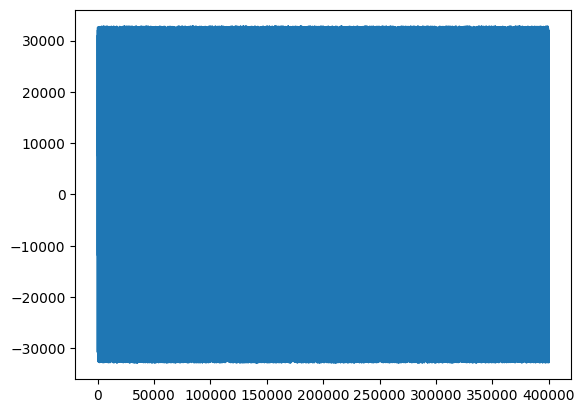

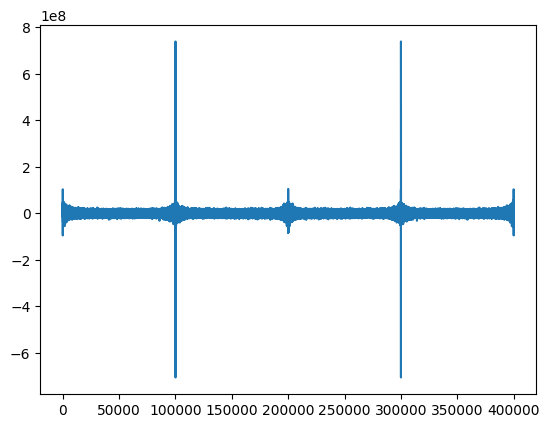

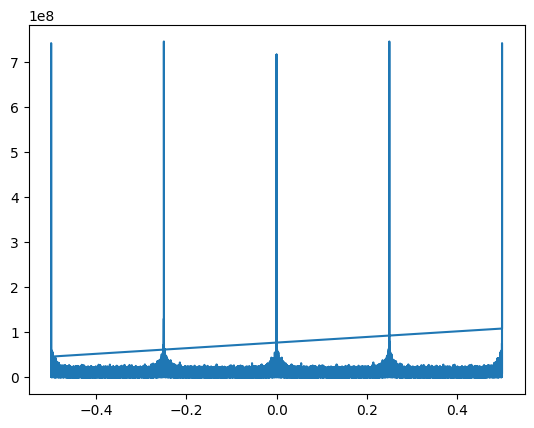

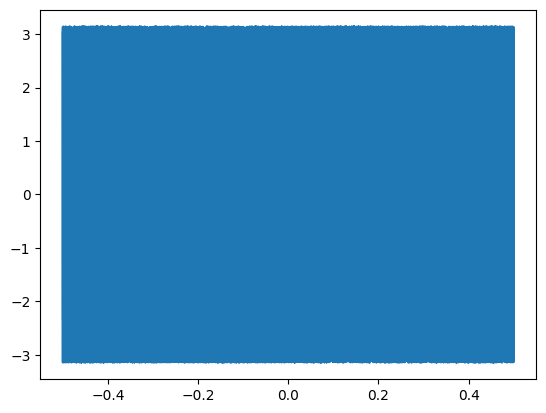

In [60]:
# My FFT implementation (I don't think this is correct)

import matplotlib.pyplot as plt
import numpy as np
import wave

def open_plot_file():

    file_path = './outputs/test.wav'

    audio_data = wave.open(file_path, 'r')

    audio_signal = audio_data.readframes(-1)
    audio_signal = np.frombuffer(audio_signal, dtype='int16')
    
    print(audio_signal)

    plt.figure(1)
    plt.plot(audio_signal)

    audio_fft = np.fft.fft(audio_signal)
    audio_freq = np.fft.fftfreq(len(audio_signal))
    
    print(audio_fft)
    
    plt.figure(2)
    plt.plot(audio_fft)
    
    Y    = np.fft.fft(audio_signal)
    freq = np.fft.fftfreq(len(audio_signal))

    plt.figure()
    plt.plot( freq, np.abs(Y) )
    plt.figure()
    plt.plot(freq, np.angle(Y) )
    plt.show()

def bandpass_filter(low_frequency, high_frequency, fs, num_taps = 101):
    pass

open_plot_file()

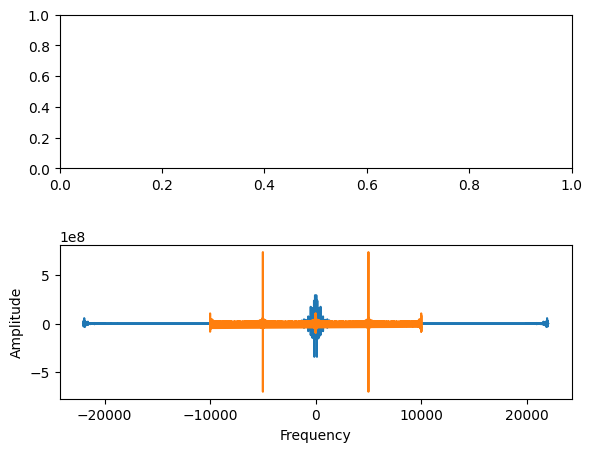

In [58]:
# FFT code from Kaden
import numpy as np
import wave
import matplotlib.pyplot as plt
import os

def perform_fft(signal, sample_rate):
    # perform the FFT
    fft = np.fft.fft(signal)
    # calculate the frequency bins
    frequency_bins = np.fft.fftfreq(len(signal), 1 / sample_rate)
    return fft, frequency_bins

files = ['electric_guitar_sample.wav', './outputs/test.wav']
files_set = set(files)
#create subplots
fig, files_set = plt.subplots(len(files))

# Open wave file
# iterate through files in audio_samples
for i, file  in enumerate(files):
    wav_file = wave.open('./' + file, 'r')

    # Extract Raw Audio from Wav File
    signal = wav_file.readframes(-1)
    frame_rate = wav_file.getframerate()
    signal = np.frombuffer(signal, dtype='int16')

    fft_out, frequency_bins = perform_fft(signal, frame_rate)

    #plot the fft
    plt.plot(frequency_bins, fft_out)

    plt.xlabel('Frequency')
    plt.ylabel('Amplitude')

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, hspace=0.5, wspace=0.5)
#show all the plots
plt.show()